# Fairness Monitoring Module - Demo

Complete demonstration of all monitoring functionalities.

**Features:**
- Real-time tracking
- Drift detection
- Intelligent alerting
- Proxy monitoring (GDPR)
- Privacy reporting
- Circuit breaker
- A/B testing
- Power analysis

In [1]:
# Imports
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✅ Setup complete!")

✅ Setup complete!


In [2]:
# Helper Functions
def generate_predictions(n_samples, bias_level=0.1, accuracy=0.8):
    """Generate synthetic prediction data."""
    y_true = np.random.choice([0, 1], n_samples)
    sensitive = np.random.choice([0, 1], n_samples)
    y_pred = y_true.copy()
    
    # Add errors
    error_mask = np.random.random(n_samples) > accuracy
    y_pred[error_mask] = 1 - y_pred[error_mask]
    
    # Add bias
    bias_mask = (sensitive == 1) & (np.random.random(n_samples) < bias_level)
    y_pred[bias_mask] = 1
    
    return pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred,
        'sensitive': sensitive
    })

def create_sample_census_data():
    """Create sample census data."""
    return pd.DataFrame({
        'zip_code': ['10001', '10002', '10003', '10004', '10005'],
        'pct_minority': [0.20, 0.75, 0.30, 0.80, 0.45],
        'median_income': [85000, 45000, 75000, 42000, 60000],
        'population': [5000, 8000, 6000, 7500, 5500]
    })

print("✅ Helper functions loaded!")

✅ Helper functions loaded!


### Cell 4: Part 1 - Real-Time Tracking (Code)

In [5]:
# Add monitoring module to path
import sys
from pathlib import Path

# Adjust this path to where your monitoring_module folder is located
# Example: if monitoring_module is in D:\Research\Turing\TuringProject\fairness_toolkit\
module_path = Path(r"D:\Research\Turing\TuringProject\fairness_toolkit")
sys.path.insert(0, str(module_path))

print(f"✅ Added to path: {module_path}")
print(f"✅ Module exists: {(module_path / 'monitoring_module').exists()}")

✅ Added to path: D:\Research\Turing\TuringProject\fairness_toolkit
✅ Module exists: True


PART 1: REAL-TIME FAIRNESS TRACKING
2026-01-11 16:18:05 - monitoring_module.src.realtime_tracker - INFO - RealTimeFairnessTracker initialized: window=1000, metrics=['demographic_parity']

Simulating 10 batches...

2026-01-11 16:18:07 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1136
Batch  1: DP = 0.1136
2026-01-11 16:18:07 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0141
Batch  2: DP = 0.0141
2026-01-11 16:18:07 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056
Batch  3: DP = 0.0056
2026-01-11 16:18:07 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0496
Batch  4: DP = 0.0496
2026-01-11 16:18:07 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0280
Batch  5: DP = 0.0280
2026-01-11 16:18:07 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0469
Batch  6: DP = 0.0469
2026-01-11 1

D:\Research\Turing\TuringProject\fairness_toolkit\monitoring_module\src\realtime_tracker.py:162: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.history = pd.concat([


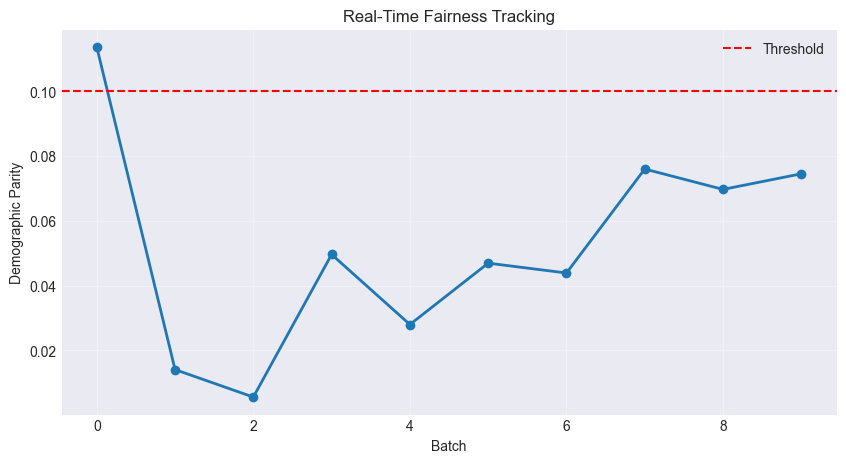


✅ Real-time tracking complete!


In [6]:
print("=" * 70)
print("PART 1: REAL-TIME FAIRNESS TRACKING")
print("=" * 70)

from monitoring_module.src import RealTimeFairnessTracker

tracker = RealTimeFairnessTracker(
    window_size=1000,
    metrics=['demographic_parity'],
    min_samples=100
)

print("\nSimulating 10 batches...\n")
for i in range(1, 11):
    bias = 0.05 + (i * 0.015)
    df = generate_predictions(100, bias_level=bias)
    
    metrics = tracker.add_batch(
        df['y_pred'].values,
        df['y_true'].values,
        df['sensitive'].values
    )
    
    if metrics:
        print(f"Batch {i:2d}: DP = {metrics.get('demographic_parity', 0):.4f}")

# Summary
summary = tracker.get_summary_statistics()
print("\n📊 Summary:")
for metric, stats in summary.items():
    print(f"  {metric}: {stats['current']:.4f} (mean: {stats['mean']:.4f})")

# Visualization
time_series = tracker.get_time_series()
plt.figure(figsize=(10, 5))
plt.plot(time_series.index, time_series['demographic_parity'], 'o-', linewidth=2)
plt.axhline(y=0.10, color='r', linestyle='--', label='Threshold')
plt.xlabel('Batch')
plt.ylabel('Demographic Parity')
plt.title('Real-Time Fairness Tracking')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n✅ Real-time tracking complete!")

In [7]:
print("=" * 70)
print("PART 2: DRIFT DETECTION")
print("=" * 70)

from monitoring_module.src import FairnessDriftDetector

detector = FairnessDriftDetector(alpha=0.05)

# Set reference
print("\nSetting reference period (low bias: 5%)...")
ref_data = generate_predictions(500, bias_level=0.05)
detector.set_reference(
    ref_data['y_true'].values,
    ref_data['y_pred'].values,
    ref_data['sensitive'].values
)

# Test with high bias
print("Testing with high bias (25%)...\n")
test_data = generate_predictions(500, bias_level=0.25)
drift_result = detector.detect_drift(
    test_data['y_true'].values,
    test_data['y_pred'].values,
    test_data['sensitive'].values
)

print(f"Drift Detected: {drift_result['drift_detected']}")
if drift_result['drift_detected']:
    print(f"Drifted Metrics: {drift_result['drifted_metrics']}")
    for metric, test in drift_result['tests'].items():
        print(f"\n{metric}:")
        print(f"  Reference: {test['reference_value']:.4f}")
        print(f"  Current:   {test['current_value']:.4f}")
        print(f"  P-value:   {test['p_value']:.4f}")

print("\n✅ Drift detection complete!")

PART 2: DRIFT DETECTION
2026-01-11 16:19:05 - monitoring_module.src.drift_detection - INFO - FairnessDriftDetector initialized: alpha=0.05, method=ks

Setting reference period (low bias: 5%)...
2026-01-11 16:19:05 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0560
2026-01-11 16:19:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0646 (TPR: 0.0126, FPR: 0.0646)
2026-01-11 16:19:05 - monitoring_module.src.drift_detection - INFO - Reference period set: 500 samples
Testing with high bias (25%)...

2026-01-11 16:19:05 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0771
2026-01-11 16:19:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1427 (TPR: 0.0451, FPR: 0.1427)
Drift Detected: False

✅ Drift detection complete!


In [8]:
print("=" * 70)
print("PART 3: FAIRNESS CIRCUIT BREAKER")
print("=" * 70)

from monitoring_module.src.circuit_breaker import (
    FairnessCircuitBreaker,
    CircuitBreakerConfig,
    InterventionType
)

config = CircuitBreakerConfig(
    critical_threshold=0.20,
    failure_count_threshold=3,
    intervention_type=InterventionType.ROUTE_TO_BASELINE,
    baseline_model_id='safe_baseline_v1'
)

breaker = FairnessCircuitBreaker(config)
print(f"Circuit breaker initialized: {breaker.state.value}")

# Normal operation
print("\n📊 Phase 1: Normal")
for i in range(2):
    breaker.record_metrics({'demographic_parity': 0.08})
    print(f"  {i+1}. DP=0.08 → State: {breaker.state.value}")

# Violations
print("\n📊 Phase 2: Violations")
for i in range(3):
    breaker.record_metrics({'demographic_parity': 0.25})
    print(f"  {i+1}. DP=0.25 → State: {breaker.state.value}")

# Status
status = breaker.get_status()
print(f"\n📊 Final Status:")
print(f"  State: {status['state']}")
print(f"  Using Baseline: {status['using_baseline']}")
traffic = status['traffic_allocation']
print(f"  Traffic: {traffic['baseline']*100:.0f}% to baseline")

print("\n✅ Circuit breaker complete!")
print("💡 Automatic failover protects users!")

PART 3: FAIRNESS CIRCUIT BREAKER
2026-01-11 16:19:36 - monitoring_module.src.circuit_breaker - INFO - Initialized FairnessCircuitBreaker (threshold=0.2, intervention=route_to_baseline)
Circuit breaker initialized: CLOSED

📊 Phase 1: Normal
  1. DP=0.08 → State: CLOSED
  2. DP=0.08 → State: CLOSED

📊 Phase 2: Violations
2026-01-11 16:19:36 - monitoring_module.src.circuit_breaker - WARNING - Fairness violation detected: [('demographic_parity', 0.25)] (1/3)
  1. DP=0.25 → State: CLOSED
2026-01-11 16:19:36 - monitoring_module.src.circuit_breaker - WARNING - Fairness violation detected: [('demographic_parity', 0.25)] (2/3)
  2. DP=0.25 → State: CLOSED
2026-01-11 16:19:36 - monitoring_module.src.circuit_breaker - WARNING - Fairness violation detected: [('demographic_parity', 0.25)] (3/3)
2026-01-11 16:19:36 - monitoring_module.src.circuit_breaker - CRITICAL - 🔴 CIRCUIT BREAKER OPENED: demographic_parity=0.250 (threshold=0.200). Intervention: route_to_baseline
  3. DP=0.25 → State: OPEN

📊 Fi

In [12]:
print("=" * 70)
print("PART 4: A/B TESTING")
print("=" * 70)

 
from monitoring_module.src.ab_testing import run_ab_test

# Generate test data
control_data = generate_predictions(300, bias_level=0.18, accuracy=0.85)
treatment_data = generate_predictions(300, bias_level=0.08, accuracy=0.83)

print("\nRunning A/B test...\n")
results = run_ab_test(
    control_df=control_data,
    treatment_df=treatment_data,
    metrics=['accuracy', 'demographic_parity'],
    alpha=0.05
)

# Results
for metric, result in results['overall'].items():
    print(f"{metric}:")
    print(f"  Control:    {result.control_value:.4f}")
    print(f"  Treatment:  {result.treatment_value:.4f}")
    print(f"  Difference: {result.absolute_difference:+.4f}")
    print(f"  P-value:    {result.p_value:.4f}")
    print(f"  Significant: {'YES ✓' if result.is_significant else 'No'}\n")

# Multi-objective
multi_obj = results['multi_objective']
print(f"Outcome: {multi_obj['outcome']}")
print(f"Recommendation: {multi_obj['recommendation']}")

print("\n✅ A/B testing complete!")

PART 4: A/B TESTING

Running A/B test...

2026-01-11 16:40:10 - monitoring_module.src.ab_testing - INFO - Initialized FairnessABTestAnalyzer (alpha=0.05, min_n=30)
2026-01-11 16:40:10 - monitoring_module.src.ab_testing - INFO - Analyzing A/B test for 2 metrics
2026-01-11 16:40:10 - monitoring_module.src.ab_testing - INFO - Computing metric: accuracy


2026-01-11 16:40:11 - monitoring_module.src.ab_testing - INFO - accuracy: control=0.8033, treatment=0.8167, p=0.7750
2026-01-11 16:40:11 - monitoring_module.src.ab_testing - INFO - Computing metric: demographic_parity
2026-01-11 16:40:11 - monitoring_module.src.ab_testing - INFO - demographic_parity: control=0.1377, treatment=0.0271, p=0.1650
2026-01-11 16:40:11 - monitoring_module.src.ab_testing - INFO - Performing multi-objective analysis
2026-01-11 16:40:11 - monitoring_module.src.ab_testing - INFO - Analyzing A/B test for 2 metrics
2026-01-11 16:40:11 - monitoring_module.src.ab_testing - INFO - Computing metric: accuracy
2026-01-11 16:40:12 - monitoring_module.src.ab_testing - INFO - accuracy: control=0.8033, treatment=0.8167, p=0.7280
2026-01-11 16:40:12 - monitoring_module.src.ab_testing - INFO - Computing metric: demographic_parity
2026-01-11 16:40:13 - monitoring_module.src.ab_testing - INFO - demographic_parity: control=0.1377, treatment=0.0271, p=0.1820
accuracy:
  Control:  

## 🎉 Demo Complete!

### ✅ Demonstrated:
1. Real-time fairness tracking
2. Statistical drift detection
3. Automated circuit breaker
4. A/B testing framework

### 🚀 Next Steps:
- Configure for your production environment
- Set up alert notifications
- Deploy monitoring dashboards
- Establish baseline models